## Loss Visualization

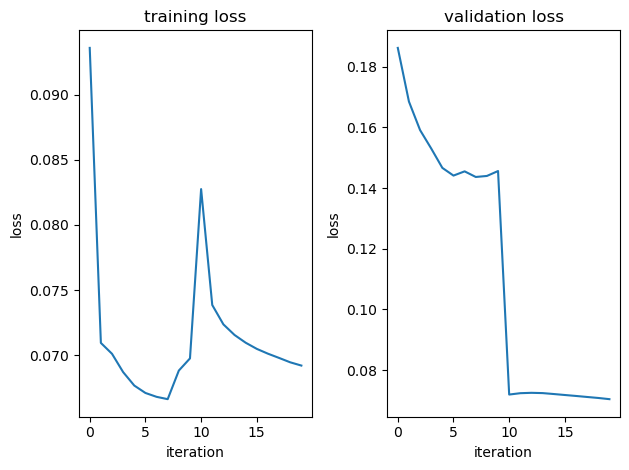

In [8]:
import numpy as np
import matplotlib.pyplot as plt

train_loss = np.load("train_loss.npy")
validation_loss = np.load("validation_loss.npy")

fig, axs = plt.subplots(1, 2)

axs[0].plot(train_loss)
axs[0].set_title('training loss')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')

axs[1].plot(validation_loss)
axs[1].set_title('validation loss')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')

plt.tight_layout()
plt.show()

## Visualization Results

In [2]:
point_labels = [
    'pelvis', 'left_hip', 'right_hip',      # 2
    'spine1', 'left_knee', 'right_knee',    # 5
    'spine2', 'left_ankle', 'right_ankle',  # 8
    'spine3', 'left_foot', 'right_foot',    # 11
    'neck', 'left_collar', 'right_collar',  # 14
    'jaw',                                  # 15
    'left_shoulder', 'right_shoulder',      # 17
    'left_elbow', 'right_elbow',            # 19
    'left_wrist', 'right_wrist',            # 21
    'left_thumb', 'right_thumb',
    'head', 'left_middle', 'right_middle',  # 26
    'left_bigtoe', 'right_bigtoe'
]

skeleton_lines = [
    #  ( (start group), (end group) ),
    (('pelvis',), ('left_hip',)),
    (('pelvis',), ('right_hip',)),
    (('left_hip',), ('left_knee',)), 
    (('right_hip',), ('right_knee',)),
    (('left_knee',), ('left_ankle',)), 
    (('right_knee',), ('right_ankle',)),
    (('left_ankle',), ('left_foot',)),
    (('right_ankle',), ('right_foot',)),
    (('pelvis',), ('spine1',)), 
    (('spine1',), ('spine2',)),
    (('spine2',), ('spine3',)),
    (('spine3',), ('neck',)),
    (('spine3',), ('left_collar',)),
    (('spine3',), ('right_collar',)),
    (('neck',), ('jaw',)),
    (('left_collar',), ('left_shoulder',)), 
    (('right_collar',), ('right_shoulder',)), 
    (('left_shoulder',), ('left_elbow',)),
    (('right_shoulder',), ('right_elbow',)), 
    (('left_elbow',), ('left_wrist',)), 
    (('right_elbow',), ('right_wrist',)), 
    (('left_wrist',), ('left_thumb',)), 
    (('right_wrist',), ('right_thumb',)), 
    (('neck',), ('head',)),
    # (('left_shoulder',), ('left_middle',)),
    # (('right_shoulder',), ('right_middle',)),
    (('left_ankle',), ('left_bigtoe',)),
    (('right_ankle',), ('right_bigtoe',)),
]

In [3]:
from glob import glob
from tqdm import tqdm
import numpy as np
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import juggle_axes
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [4]:
skeleton_idxs = []
for g1, g2 in skeleton_lines:
    entry = []
    entry.append([point_labels.index(l) for l in g1])
    entry.append([point_labels.index(l) for l in g2])
    skeleton_idxs.append(entry)

# Cloud of every point connected:
cloud_idxs = []
cloud_idxs_names = []

all_idxs = skeleton_idxs + cloud_idxs

def get_line_segments(seq, zcolor=None, cmap=None, cloud=False, edge_types=None, edge_class=None):
    xline = np.zeros((seq.shape[0], len(all_idxs), 3, 2))
    if cmap:
        colors = np.zeros((len(all_idxs), 4))
    for edge,(joint1,joint2) in enumerate(all_idxs):
        xline[:,edge,:,0] = np.mean(seq[:, joint1], axis=1)
        xline[:,edge,:,1] = np.mean(seq[:, joint2], axis=1)    
        if cmap:
            if edge_types is not None:
                if edge >= len(skeleton_idxs): # cloud edges
                    if edge_types[edge - len(skeleton_idxs), edge_class] == 1:
                        colors[edge] = cmap(1)
                    else:
                        colors[edge] = cmap(0)
            else:
                colors[edge] = cmap(0)
    if cmap:
        return xline, colors
    else:
        return xline
    
# put line segments on the given axis, with given colors
def put_lines(ax, segments, color=None, lw=2.5, alpha=None, skeleton=True, skeleton_alpha=0.3, cloud=False, cloud_alpha=0.03, threshold=0, edge_types=None, edge_opacities=None, edge_class=None):
    lines = []
    ### Main skeleton
    for i in tqdm(range(len(skeleton_idxs)), desc="Skeleton lines"):
        if isinstance(color, (list,tuple,np.ndarray)):
            c = color[i]
        else:
            c = color
                        
        if skeleton: alpha = skeleton_alpha
        else: alpha = 0
            
        ### THESE LINES PLOT THE MAIN SKELETON
        l = ax.plot(np.linspace(segments[i, 0, 0],segments[i, 0, 1], 2),
                np.linspace(segments[i, 1, 0], segments[i, 1, 1], 2),
                np.linspace(segments[i, 2, 0], segments[i, 2, 1], 2),
                color=c,
                alpha=alpha,
                lw=lw)[0]
        lines.append(l)
    
    if cloud:
        ### Cloud of all-connected joints
        for i in tqdm(range(len(cloud_idxs)), desc="Cloud lines"):
            if isinstance(color, (list, tuple, np.ndarray)):
                c = color[i]
            else:
                c = color
                
            ### plot or don't plot lines based on edge class
            if edge_types is not None and edge_class is not None:
                custom_colors = ["deeppink", "red", "blue", "green", "orange"]
                if edge_types[i][edge_class] == 1:
                    if edge_opacities is not None and edge_opacities[i, edge_class] > threshold: # and cloud_idxs[i][1] == [10]:
                        alpha = 0.5 #edge_opacities[i,edge_class]
                        print("Surviving edge: {} | ({} -> {}), i.e. ({} -> {})".format(i, cloud_idxs[i][0],  cloud_idxs[i][1], cloud_idxs_names[i][0], cloud_idxs_names[i][1]))
                    else:
                        alpha = cloud_alpha
                    l = ax.plot(
                        np.linspace(segments[i, 0, 0], segments[i, 0, 1], 2),
                        np.linspace(segments[i, 1, 0], segments[i, 1, 1], 2),
                        np.linspace(segments[i, 2, 0], segments[i, 2, 1], 2),
                        color=custom_colors[edge_class],
                        alpha=alpha,
                        lw=lw)[0]
                    lines.append(l)
                else:
                    l = ax.plot(
                        np.linspace(segments[i, 0, 0], segments[i, 0, 1], 2),
                        np.linspace(segments[i, 1, 0], segments[i, 1, 1], 2),
                        np.linspace(segments[i, 2, 0], segments[i, 2, 1], 2),
                        alpha=0,
                        color="white",
                        lw=lw)[0]
                    lines.append(None)
                    
            else: # regular cloud
                l = ax.plot(
                np.linspace(segments[i, 0, 0], segments[i, 0, 1], 2),
                np.linspace(segments[i, 1, 0], segments[i, 1, 1], 2),
                np.linspace(segments[i, 2, 0], segments[i, 2, 1], 2),
                alpha=cloud_alpha,
                lw=lw)[0]
                lines.append(l)
    return lines

# animate a video of the stick figure.
# `ghost` may be a second sequence, which will be superimposed on the primary sequence.
# If ghost_shift is given, the primary and ghost sequence will be separated laterally by that amount.
# `zcolor` may be an N-length array, where N is the number of vertices in seq, and will be used to color the vertices. Typically this is set to the avg. z-value of each vtx.
def animate_stick(seq, ghost=None, ghost_shift=0, edge_types=None, edge_opacities=None, threshold=0, edge_class=None, figsize=None, zcolor=None, pointer=None, ax_lims=(-0.4, 0.4), speed=45, dot_size=20, dot_alpha=0.5, lw=2.5, cmap='cool_r', pointer_color='black', cloud=False, cloud_alpha=0.03, skeleton=True, skeleton_alpha=0.3):
    if zcolor is None:
        zcolor = np.zeros(seq.shape[1])
    fig = plt.figure(figsize=figsize)
    ax = p3.Axes3D(fig)
    
    # The following lines eliminate background lines/axes:
    # ax.axis('off')
    # ax.xaxis.set_visible(False)
    # ax.yaxis.set_visible(False)
    # ax.set_frame_on(False)
    
    # set figure background opacity (alpha) to 0:
    fig.patch.set_alpha(0.)
    
    if ghost_shift and ghost is not None:
        seq = seq.copy()
        ghost = ghost.copy()
        seq[:, :, 0] -= ghost_shift
        ghost[:, :, 0] += ghost_shift
    
    cm = matplotlib.cm.get_cmap(cmap)
    
    if edge_types is not None:
        num_connections = np.zeros((24))
        for edge, (joint1, joint2) in enumerate(all_idxs):
            if edge > len(skeleton_idxs) and edge_types[edge - len(skeleton_idxs), edge_class] == 1:
                num_connections[joint1] += 1
                num_connections[joint2] += 1
        num_connections = num_connections / np.sum(num_connections) # normalize so colormap can use values between 0 and 1
        dot_color = [cm(num_connections[joint]) for joint in range(24)]
        pts = ax.scatter(seq[0, :, 0], seq[0, :, 1], seq[0, :, 2], c=dot_color, s=dot_size, cmap=cm, alpha=dot_alpha)

    else:
        dot_color = "black"
        pts = ax.scatter(seq[0, :, 0], seq[0, :, 1], seq[0, :, 2], c=dot_color, s=dot_size, cmap=cm, alpha=dot_alpha)

    ghost_color = 'blue'

    if ghost is not None:
        pts_g = ax.scatter(ghost[0, :, 0], ghost[0, :, 1], ghost[0, :, 2], c=ghost_color, s=dot_size, alpha=dot_alpha)
    
    if ax_lims:
        ax.set_xlim(*ax_lims)
        ax.set_ylim(*ax_lims)
        ax.set_zlim(*ax_lims)
    plt.close(fig)
    xline, colors = get_line_segments(seq, zcolor, cm, edge_types=edge_types, edge_class=edge_class)
    lines = put_lines(ax, xline[0], color=colors, lw=lw, alpha=0.9, cloud=cloud, cloud_alpha=cloud_alpha, edge_types=edge_types, edge_opacities=edge_opacities, threshold=threshold, edge_class=edge_class, skeleton=skeleton, skeleton_alpha=skeleton_alpha)
    
    if ghost is not None:
        xline_g = get_line_segments(ghost)
        lines_g = put_lines(ax, xline_g[0], ghost_color, lw=lw, alpha=1.0, cloud=cloud, cloud_alpha=cloud_alpha, skeleton=skeleton, skeleton_alpha=skeleton_alpha)
    
    if pointer is not None:
        vR = 0.15
        dX, dY = vR * np.cos(pointer), vR * np.sin(pointer)
        zidx = point_labels.index('CLAV')
        X = seq[:, zidx, 0]
        Y = seq[:, zidx, 2]
        Z = seq[:, zidx, 1]
        quiv = ax.quiver(X[0], Y[0], Z[0], dX[0], dY[0], 0, color=pointer_color)
        ax.quiv = quiv
    
    def update(t):
        pts._offsets3d = juggle_axes(seq[t, :, 0], seq[t, :, 1], seq[t, :, 2], 'z')
        for i,l in enumerate(lines):
            if l is not None:
                l.set_data(xline[t, i, :2])
                l.set_3d_properties(xline[t, i, 2])
        
        if ghost is not None:
            pts_g._offsets3d = juggle_axes(ghost[t, :, 0], ghost[t, :, 1], ghost[t, :, 2], 'z')
            for i,l in enumerate(lines_g):
                l.set_data(xline_g[t, i, :2])
                l.set_3d_properties(xline_g[t, i, 2])
        
        if pointer is not None:
            ax.quiv.remove()
            ax.quiv = ax.quiver(X[t], Y[t], Z[t], dX[t], dY[t], 0, color=pointer_color)
    
    return animation.FuncAnimation(
        fig,
        update,
        len(seq),
        interval=speed,
        blit=False,
    )

In [6]:
seq1 = np.load("seq1_original_1.npy")
seq2_original = np.load("seq2_original_1.npy")
seq2_next_ts = np.load("seq2_next_ts_1.npy")

seq1 = seq1[..., [2, 0, 1]]
seq1[..., 2] = -seq1[..., 2]

seq2_next_ts = seq2_next_ts[..., [2, 0, 1]]
seq2_next_ts[..., 2] = -seq2_next_ts[..., 2]

seq2_original = seq2_original[..., [2, 0, 1]]
seq2_original[..., 2] = -seq2_original[..., 2]

In [ ]:
ani = animate_stick(seq1, 
                    ghost=seq2_original, 
                    # ghost_shift=-0.2,
                    figsize=(10, 8), 
                    speed=100,
                    cmap='inferno', 
                    cloud=False, 
                    ax_lims=(-1.3, 1.4)
    )

animation_js = ani.to_jshtml()
display(HTML(animation_js))